<a href="https://colab.research.google.com/github/Mallika44/QM2/blob/main/Copy_of_W4_Natural_Language_Processing_Student_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing

## *Workshop 4*  [![Open In Colab](https://github.com/oballinger/QM2/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/oballinger/QM2/blob/main/notebooks/W04.%20Natural%20Language%20Processing.ipynb)


## Background

Exxon Mobil is the 4th largest oil company in the world. In 1978, an Exxon scientist named James Black wrote an [internal briefing](https://insideclimatenews.org/documents/james-black-1977-presentation/) called "The Greenhouse Effect" in which he warned: “Present thinking holds that man has a time window of five to ten years before the need for hard decisions regarding changes in energy strategies might become critical.”

Rather than acting on this information, Exxon spent the next [forty years aggressively funding climate denial](https://news.harvard.edu/gazette/story/2021/09/oil-companies-discourage-climate-action-study-says/). Recently, [a U.S. court ruled](https://www.theguardian.com/environment/2022/may/24/exxon-trial-climate-crimes-fossil-fuels-global-heating) that ExxonMobil must face trial over accusations that it lied about the climate crisis and covered up the fossil fuel industry’s role in worsening environmental devastation.

### Earnings Calls
Every three months, Exxon conducts an ["earnings call"](https://www.investopedia.com/terms/e/earnings-call.asp); a conference call between the management of a public company, analysts, investors, and the media to discuss the company’s financial results during a given reporting period, such as a quarter or a fiscal year.

You can [register](https://globalmeet.webcasts.com/starthere.jsp?ei=1488251&tp_key=440e363aaf) to attend their next one if you want! No worries if you miss it, they provide [transcripts](https://corporate.exxonmobil.com/Investors/Investor-relations/Investor-materials-archive#Quarterlyearningsmaterials) on their website.

These transcripts provide an intimate window into the company's dealings. We can see how much pressure investors are putting on the company to tackle climate change, and how the company responds.

We'll be working with transcripts spanning nealry 20 years and over 10 million words; that's like reading the Harry Potter series 10 times. Then, we'll look at a sample of 100,000 tweets that use the #ExxonKnew hashtag, and analyze public pressure on the company.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


![](https://haha.business/business.jpg)


## Downloading the Data
Let's grab the data we will need this week from our course website and save it into our data folder. If you've not already created a data folder then do so using the following command.

Don't worry if it generates an error, that means you've already got a data folder.

In [2]:
%%capture
!pip install spacy
!pip install scattertext
!pip install tika
!pip install spacytextblob
!pip install Basemap
!pip install ipyleaflet
!pip install Map
!pip install Marker
!pip install basecamps
!pip install basemap_to_tiles
!pip install Circle

In [3]:
#Make a ./data/wk4 directory
!mkdir data
!mkdir data/wk4

In [4]:
!curl https://storage.googleapis.com/qm2/wk4/Exxon.json -o data/wk4/Exxon.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.5M  100 10.5M    0     0  27.0M      0 --:--:-- --:--:-- --:--:-- 27.0M


In [5]:
import spacy
import json
import pylab
from IPython.core.display import display, HTML
import nltk
from tika import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob
import ipyleaflet


%matplotlib inline
pylab.rcParams['figure.figsize'] = (10., 8.)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

## Downloading and reading one earnings call

Exxon host earnings calls on their website in PDF form. Usually, working with PDFs is a real pain as they are not machine-readable. Using a python package called [tika](https://www.geeksforgeeks.org/parsing-pdfs-in-python-with-tika/), we can "parse" a pdf, turning it into machine-readable text:

In [6]:
# define the URL where your PDF lives. You could also upload your own pdf.
#url='https://corporate.exxonmobil.com/-/media/Global/Files/investor-relations/quarterly-earnings/earnings-transcripts/2022-earnings-transcripts/1Q22-XOM-Earnings-Call-Transcript-4-29-22.pdf'
url='https://d1io3yog0oux5.cloudfront.net/_74d009918ead0ec6acdd6bbaf27a8316/exxonmobil/db/2288/22123/earnings_release/XOM+2Q23+Earnings+Press+Release+Website.pdf'
# parse the pdf by feeding tika the URL and store the text in an object called "raw"
raw = parser.from_file(url)


2023-12-12 13:23:55,516 [MainThread  ] [INFO ]  Retrieving https://d1io3yog0oux5.cloudfront.net/_74d009918ead0ec6acdd6bbaf27a8316/exxonmobil/db/2288/22123/earnings_release/XOM+2Q23+Earnings+Press+Release+Website.pdf to /tmp/_74d009918ead0ec6acdd6bbaf27a8316-exxonmobil-db-2288-22123-earnings_release-xom-2q23-earnings-press-release-website.pdf.
INFO:tika.tika:Retrieving https://d1io3yog0oux5.cloudfront.net/_74d009918ead0ec6acdd6bbaf27a8316/exxonmobil/db/2288/22123/earnings_release/XOM+2Q23+Earnings+Press+Release+Website.pdf to /tmp/_74d009918ead0ec6acdd6bbaf27a8316-exxonmobil-db-2288-22123-earnings_release-xom-2q23-earnings-press-release-website.pdf.
2023-12-12 13:23:56,010 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar to /tmp/tika-server.jar.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2

Now, we have an object called "raw" that contains some useful information. Notice the squiggly brackets; this is a dictionary. It contains several fields, including some useful metadata such as the author

In [7]:
raw['metadata']['pdf:docinfo:created']

'2023-07-27T20:47:01Z'

In [8]:
date=raw['metadata']['pdf:docinfo:created']
title=raw['metadata']['dc:title']
raw_text=raw['content']

print('Date: ', date)
print('Title: ', title)
print('Word Count: ', len(raw_text))
print('Text:')
raw_text

Date:  2023-07-27T20:47:01Z
Title:  f8k2Q23991
Word Count:  52501
Text:


"\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nf8k2Q23991\n\n\n2Q 2023 Earnings Release\nFOR IMMEDIATE RELEASE July 28, 2023\n\nExxonMobil Announces Second-Quarter 2023 Results\n• Structural earnings improvements contributed to strong second-quarter earnings of $7.9 billion\n\n• Achieved record quarterly production in the Permian and Guyana, demonstrating excellent operational \nperformance\n\n• Highest second-quarter global refinery throughput in the last 15 years1\n\n• Expanded leadership in carbon capture and storage by agreeing to acquire Denbury and reaching 5 million \nmetric tons per year of CO2 offtake contracts with industrial customers2 \n\nResults Summary\n\n2Q23 1Q23\nChange\n\nvs \n1Q23\n\n2Q22\nChange \n\nvs \n2Q22\n\nDollars in millions (except per share data) YTD \n2023\n\nYTD \n2022\n\nChange \nvs YTD\n2022\n\n 7,880  11,430  -3,550  17,850  -9,970 Earnings (U.S. GAAP)  19,310  23,330  -4,020 \n\n 7,874  11,618  -3,744  17,551  -9,677 Earnings E

look at that! we're beginning to give some structure to our text data. But suppose I wanted to analyze multiple earnings calls; I need to organize this data so that it can accomodate new entries. As always, we want to **tabularize** our data. Let's create a dataframe with three columns (Date, Title, and Text) in which each row is one earnings call:

In [9]:
# create a dataframe using the above data - dataframe is a matrix of rows and columns
call=pd.DataFrame({'Date':[date],'Title':[title],'Text':[raw_text]})

# remember, datetime information almost always reaches us as text.
# we need to explicitly convert it to the datetime data type.
call['Date']=pd.to_datetime(call['Date'], infer_datetime_format=True)

# Let's see what we've got.
call

,Date,Title,Text
0,2023-07-27 20:47:01+00:00,f8k2Q23991,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...


Now, if we were so inclined, we could use a loop to repeat this process for a large number of earnings calls, yielding a neatly organized dataframe containing the date, title, and text of earnings calls over time. I've done this so you don't have to, and stored it as a file called "Exxon.json". It spans 2002-2019, and contains over 10 million words' worth of earnings calls. Let's take a peek:

In [10]:
df=pd.read_json('data/wk4/Exxon.json')
df

,Title,Date,Text
0,Exxon Mobil Corp at Barclays CEO EnergyPower ...,2019-09-04,Mr. Woods joined ExxonMobil International in 1...
1,Q2 2019 Exxon Mobil Corp Earnings Call - Final,2019-08-02,"NEIL A. HANSEN, VP OF IR & SECRETARY, EXXON MO..."
2,Event Brief of Q2 2019 Exxon Mobil Corp Earn...,2019-08-02,". Neil A. Hansen - Exxon Mobil Corporation,VP ..."
3,Exxon Mobil Corp at JPMorgan Energy Conferenc...,2019-06-18,"So with that, I'll turn it over to you. Thank ..."
4,Exxon Mobil Corp Annual Shareholders Meeting ...,2019-05-29,"DARREN W. WOODS, CHAIRMAN & CEO, EXXON MOBIL C..."
...,...,...,...
177,Event Brief of Q3 2002 Exxon Mobil Corporati...,2002-10-31,OVERVIEW \n\n XOM reported normalized earnings...
178,Q3 2002 Exxon Mobil Corporation Earnings Con...,2002-10-31,"In particular, I refer you to factors affectin..."
179,Q2 2002 Exxon Mobil Corporation Earnings Con...,2002-08-01,Welcome to Exxon Mobil's teleconference and we...
180,Abstract of Q2 2002 Exxon Mobil Corporation ...,2002-08-01,OVERVIEW \n\n XOM: 2Q02 net income was $2.64b....


Great-- we've got a structured dataset of earnings calls. But even though the data has *structure*, the data in the "Text" column still needs some cleaning and processing.

## Dirty Words

Text often comes 'unclean' either containing tags such as HTML (or XML), or has other issues.
We've already done a bit of tidying, but it's been relatively straightforward. Be cautious when committing to a text analysis project - you may spend a great deal of time tidying up your text.

For example, you may have noticed "\n\n\n\n\n\n\n\n..." in the text of the first earnings call we downloaded. This is a character (just like "a" or "$") except it indicates that we want to create a new line. It's part of the formatting of the pdf. That's not really useful information to us. Let start by selecting an earnings call; i've chosen the 38th in this dataframe:

In [11]:
call=df.iloc[38]

print('Date: ', call['Date'])
print('Title: ', call['Title'])
print('Word Count: ', len(call['Text']))
print('Text:')
call['Text']

Date:  2016-05-25 00:00:00
Title:  Exxon  Mobil Corp Annual Shareholders Meeting - Final
Word Count:  125746
Text:


'I\'m Rex Tillerson, I\'m the Chairman and Chief Executive Officer of the Exxon Mobil Corporation. And I am pleased to welcome each of you that made the effort to join us today in person. I also, though, want to welcome our shareholders around the world who are joining us by way of the Internet.\n\nI do hope you had the opportunity to meet some of our employees in person while visiting the displays in the foyer this morning. These Exxon Mobil employees are among the over 73,000 people who are working 24 hours a day, seven days a week, 365 days a year on your behalf. And many of them are working in challenging locations to deliver the energy and products needed by consumers around the world.\n\nThe financial and operating results that I bring to you today are really their results, and I have the privilege of presenting them to you on their behalf.\n\nSeated next to me is Jeff Woodbury, Vice President of Investor Relations and our Corporate Secretary. He will assist me in running the mee

This call took place on May 25th, 2016. The transcript is over 125,000 words, nearly as long as the third Lord of the Rings book. It would be a pain to read all of it, so we'll use python to extract insights. Currently, the contents of `call["Text"]` is a ["string"](https://docs.python.org/3/library/stdtypes.html#text-sequence-type-str)-- a sequence of characters. We can do a number of things with strings, including splitting a big string into smaller strings using a specific delimiter and the `.split()` function. For example, I can break down the whole text of the earnings call roughly into sentences by splitting the string every time I encounter a period ("."). This returns a list of smaller strings, and if i select the first one using `[0]`, I get the first sentence of this call:

In [12]:
call['Text'].split('.')[0]

"I'm Rex Tillerson, I'm the Chairman and Chief Executive Officer of the Exxon Mobil Corporation"

Lovely! the first sentence is an introduction by then-CEO [Rex Tillerson](https://en.wikipedia.org/wiki/Rex_Tillerson).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Rex_Tillerson_official_portrait.jpg/800px-Rex_Tillerson_official_portrait.jpg.jpg" alt="drawing" width="200"/>

He was CEO of Exxon from 2006 until he retired on January 1st 2017. One month later, he was sworn in as U.S. Secretary of State under Donald Trump. Let's see what Rex thinks about climate change!

## Regular Expressions (Regex)

Another thing we can do with strings in python is search them using regular expressions. A regular expression is a sequence of characters that specifies a search pattern in text. You can play around building some regex queries using this [tool](https://regexr.com/).

You can think about this as Ctrl+F on steroids; In its simplest form, we can use regex to search for a character, word, or phrase in a bunch of text. For example, we can use regular expressions to count how many times "climate change" is mentioned in this earnings call using the `re.findall()` function:

In [13]:
# import the regular expressions library
import re

# use the findall function to search for mentions of "climate change" in the text of our call
climate_change = re.findall(r'climate change', call['Text'], re.IGNORECASE)

# this returns a list of strings matching our search term.
# the length of the list gives us the number of occurances
len(climate_change)

51

Looks like climate change is mentioned 51 times in this earnings call.



---

### Exercise

how many times is the phrase "global warming" mentioned?

---



But we have 182 earnings calls in this sample-- suppose we want to count the number of times climate change is mentioned in each one, so we can see the salience of this topic over time.

### Applying a lambda function to a dataframe

Because each row of our dataframe `df` is an earnings call (the text of which is contained in `df['Text']`, we want to apply the analysis we did for the single earnings call above to each row of `df`.

We can accomplish this using a [**lambda function**](https://www.w3schools.com/python/python_lambda.asp). This allows us to iterate over each value in a dataframe column, and apply a function to it. In the simple example below, I use a lambda function to create a new column that is takes the values from a different column and multiplies them by 2:

In [14]:
#Exercise
# import the regular expressions library
import re

# use the findall function to search for mentions of "climate change" in the text of our call
global_warming = re.findall(r'global warming', call['Text'], re.IGNORECASE)

# this returns a list of strings matching our search term.
# the length of the list gives us the number of occurances
len(global_warming)

11

In [15]:
# create a dataframe called "example" with one column called "numbers" which contains numbers 0-5
example= pd.DataFrame({'numbers':[0,1,2,3,4,5]})

# print the dataframe
print("\n Before applying lambda function: \n", example)

# create a new column called "doubled numbers"
# apply a lambda function that iterates over each row in the "numbers" column
# call each row "x", and multiply it by 2
example['doubled numbers']= example['numbers'].apply(lambda x: x*2)

# print the dataframe, which now contains the new column
print("\n \n After applying lambda function: \n", example)


 Before applying lambda function: 
    numbers
0        0
1        1
2        2
3        3
4        4
5        5

 
 After applying lambda function: 
    numbers  doubled numbers
0        0                0
1        1                2
2        2                4
3        3                6
4        4                8
5        5               10


There were simpler ways of doing this (namely, `example[doubled numbers]=example['numbers']*2`). But if we want to do something more complex, lambda functions are very useful. Remember, we used `re.findall(r'climate change', call['Text'], re.IGNORECASE)` to get a list of mentions of climate change in the text of one earnings call, and measured the length of the list using `len()` to count the number of mentions. We can turn this into a lambda function as follows:

`df['Text'].apply(lambda x: len(re.findall(r'climate change', x, re.IGNORECASE)))`

1. `df['Text']`: the column we want to iterate over.
2. `.apply(lambda x:`: iterate over each row in the column, and call each value in that column x. In other words, x will represent the text of each earnings call.
3. `len(re.findall(r'climate change', x, re.IGNORECASE)` this is exactly the same as what did previously to find the number of mentions of climate change in the one earnings call, except that we swapped `call['Text']` with `x`, since we want to do this for the text of every earnings call.

In [16]:
# create a column called "climate change" that contains the count of mentions of this keyword
df['climate change']=df['Text'].apply(lambda x: len(re.findall(r'climate change', x, re.IGNORECASE)))

# print the title of each earnings call, along with the number of mentions of climate change.
print(df[['Title','climate change']])

                                                 Title  climate change
0    Exxon  Mobil Corp at Barclays CEO EnergyPower ...               2
1     Q2 2019  Exxon  Mobil Corp Earnings Call - Final               0
2    Event Brief of Q2 2019  Exxon  Mobil Corp Earn...               0
3    Exxon  Mobil Corp at JPMorgan Energy Conferenc...               0
4    Exxon  Mobil Corp Annual Shareholders Meeting ...              25
..                                                 ...             ...
177  Event Brief of Q3 2002  Exxon  Mobil Corporati...               0
178  Q3 2002  Exxon  Mobil Corporation Earnings Con...               0
179  Q2 2002  Exxon  Mobil Corporation Earnings Con...               0
180  Abstract of Q2 2002  Exxon  Mobil Corporation ...               0
181  Exxon  Mobil Corporation First Quarter 2002 Re...               0

[182 rows x 2 columns]


Amazing! We've now got a column indicating how many times "climate change" was mentioned in each earnings call.  

---

### Exercise

Create three new columns that count the frequency of the terms "global warming", "carbon capture", and another phrase or word of your choosing. When you've done this, edit the code below so that it not only shows the frequency of "climate change" mentions, but also the three additional columns you created.

Advanced: Our current measure of the number of mentions of keywords might be biased: if one earnings call mentions climate change 10 times more than another, but that earnings call has 10 times more words, then the *rate* of keyword mentions hasn't actually increased; people are just talking more. You can get the word count of each earnings call in the lambda function above using `len(x)` (using `len()` on a string will get you a word count). Edit the lambda function above such that we don't get a *count* of the number of mentions of climate change, but the *rate* of mentions (i.e., count of "climate change" divided by total word count per call).


---


Let's plot the frequency of these mentions over time to analyze temporal trends in the salience of climate change and other keywords in these calls. We'll accomplish this using

In [17]:
# create a column called "climate change" that contains the count of mentions of this keyword
df['climate change']=df['Text'].apply(lambda x: len(re.findall(r'climate change', x, re.IGNORECASE)))
df['carbon capture']=df['Text'].apply(lambda x: len(re.findall(r'carbon capture', x, re.IGNORECASE)))
df['global warming']=df['Text'].apply(lambda x: len(re.findall(r'global warming', x, re.IGNORECASE)))
df['emissions']=df['Text'].apply(lambda x: len(re.findall(r'emissions', x, re.IGNORECASE)))

df['']=df['Text'].apply(lambda x: len(re.findall(r'global warming', x, re.IGNORECASE)))
# print the title of each earnings call, along with the number of mentions of climate change.
df[['Title','climate change', 'carbon capture', 'global warming','emissions']]

,Title,climate change,carbon capture,global warming,emissions
0,Exxon Mobil Corp at Barclays CEO EnergyPower ...,2,3,0,12
1,Q2 2019 Exxon Mobil Corp Earnings Call - Final,0,1,0,4
2,Event Brief of Q2 2019 Exxon Mobil Corp Earn...,0,1,0,4
3,Exxon Mobil Corp at JPMorgan Energy Conferenc...,0,0,0,0
4,Exxon Mobil Corp Annual Shareholders Meeting ...,25,3,2,26
...,...,...,...,...,...
177,Event Brief of Q3 2002 Exxon Mobil Corporati...,0,0,0,0
178,Q3 2002 Exxon Mobil Corporation Earnings Con...,0,0,0,0
179,Q2 2002 Exxon Mobil Corporation Earnings Con...,0,0,0,0
180,Abstract of Q2 2002 Exxon Mobil Corporation ...,0,0,0,0


<Axes: xlabel='Year'>

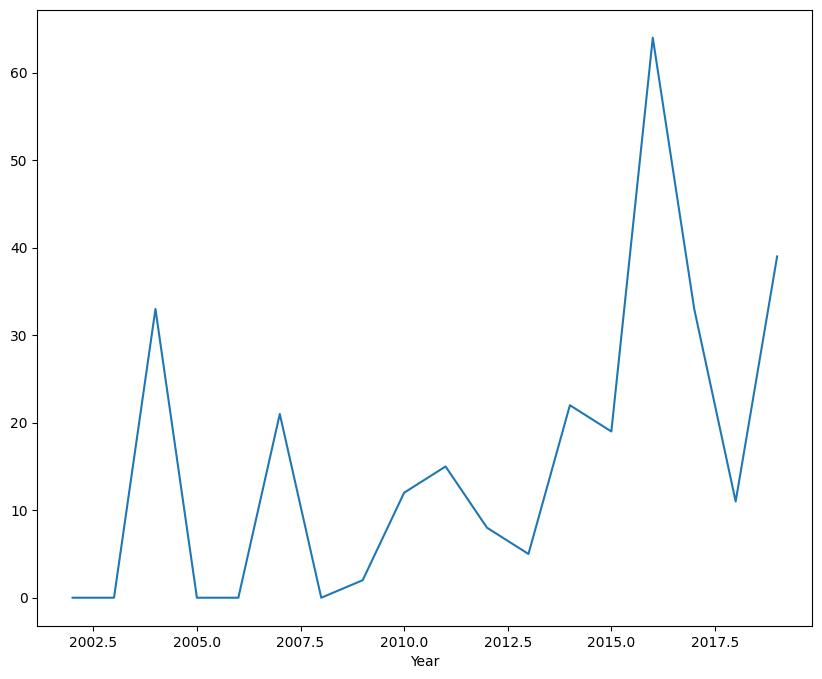

In [18]:
# extract the year from the date column
df['Year']=df['Date'].dt.year

# group the dataframe by year, calculating the sum of the "climate change" column
# save it as a new dataframe called "yearly"
yearly=df.groupby('Year')['climate change'].sum()

# plot yearly
yearly.plot()

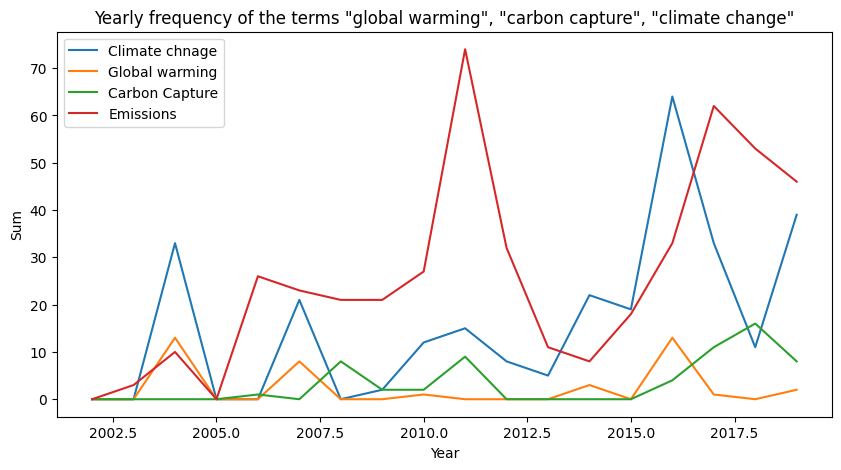

In [19]:
# extract the year from the date column
df['Year']=df['Date'].dt.year

# group the dataframe by year, calculating the sum of the "climate change" column
# save it as a new dataframe called "yearly"
yearly=df.groupby('Year')['climate change'].sum()
yearly_gw = df.groupby('Year')['global warming'].sum()
yearly_cc = df.groupby('Year')['carbon capture'].sum()
yearly_e = df.groupby('Year')['emissions'].sum()
#Plotting the data
plt.figure(figsize=(10, 5)) #Optional : Adjust the size of the plot
plt.plot(yearly, label='Climate chnage')
plt.plot(yearly_gw, label='Global warming')
plt.plot(yearly_cc, label='Carbon Capture')
plt.plot(yearly_e, label='Emissions')

#Adding labels and the title
plt.xlabel('Year')
plt.ylabel('Sum')
plt.title('Yearly frequency of the terms "global warming", "carbon capture", "climate change"')

plt.legend()
plt.show()

<Axes: xlabel='Year'>

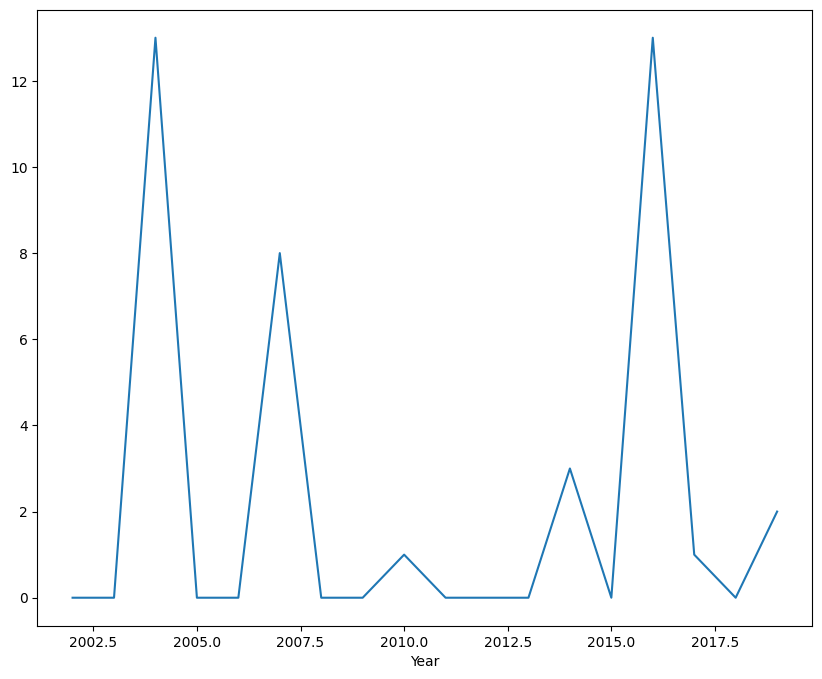

In [ ]:
# extract the year from the date column
df['Year']=df['Date'].dt.year

# group the dataframe by year, calculating the sum of the "climate change" column
# save it as a new dataframe called "yearly"
yearly=df.groupby('Year')['global warming'].sum()

# plot yearly
yearly.plot()

<Axes: xlabel='Year'>

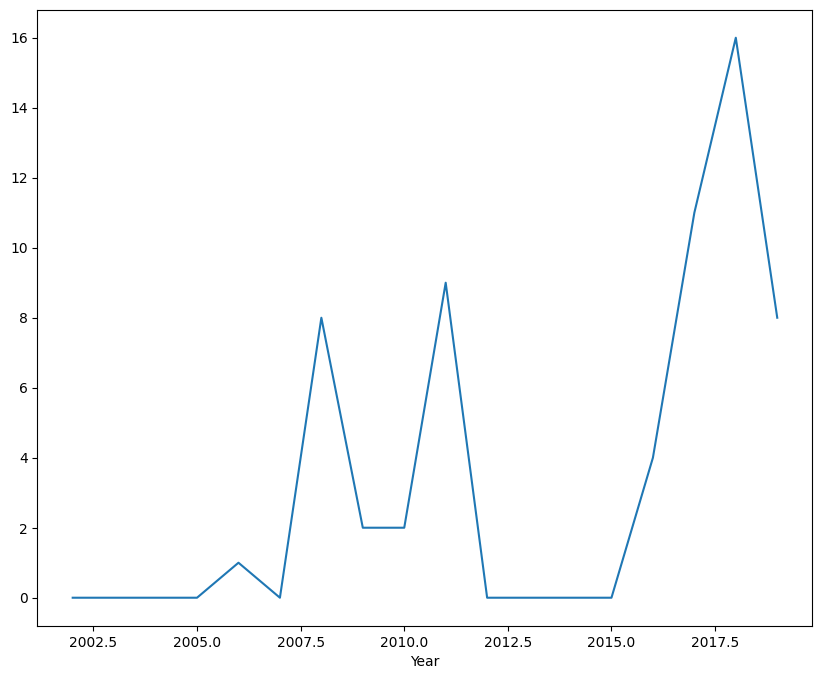

In [ ]:
# extract the year from the date column
df['Year']=df['Date'].dt.year

# group the dataframe by year, calculating the sum of the "climate change" column
# save it as a new dataframe called "yearly"
yearly=df.groupby('Year')['carbon capture'].sum()

# plot yearly
yearly.plot()

<Axes: xlabel='Year'>

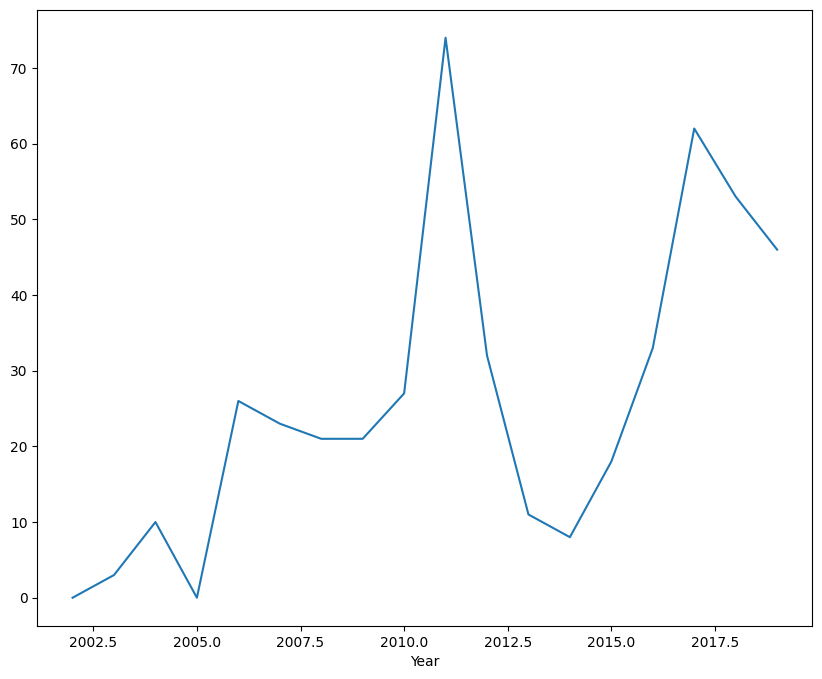

In [20]:
# extract the year from the date column
df['Year']=df['Date'].dt.year

# group the dataframe by year, calculating the sum of the "climate change" column
# save it as a new dataframe called "yearly"
yearly=df.groupby('Year')['emissions'].sum()

# plot yearly
yearly.plot()

Do you notice any patterns in the salience of these topics over time?

## Intermediate Regex

Great. We can see how frequently climate related keywords come up in earnings calls between shareholders and Exxon Mobil representatives over time. But what if we want to look at what they're actually saying?

We can get a bit fancier with Regex to look at the content of these discussions. Regex can be pretty confusing, but it's also a very powerful tool. Before moving on, let's familiarize ourselves a bit more with regex.

Let's try to extract all *sentences* containing the phrase "climate change"; the regex would look like this:

`([^.]*climate change[^.]*)`

1. `()` indicates that we want to match a group of characters, not just the characters themselves. In this case, the group is a sentence, not just the word climate change. But how do we
2. `[^.]*` we want to match all characters except periods. This will break the text up into sentences
3. `climate change` the phrase we want our sentence to contain.

when you put it all together, the regex will search for groups of characters (1.) bounded by periods (2.) that contain the phrase "climate change" (3.)

In [21]:
# create a list called "climate_sentences" that contains the results of this query
climate_sentences=re.findall(r"([^.]*climate change[^.]*)"," ".join(df['Text']))

print(len(climate_sentences))
# print the first 10 sentences in the list
for sentence in climate_sentences[:10]:
  print('\n', sentence)

251

  However, as the world looks to lower their carbon emissions and respond to the risk of climate change, there is a desire to better understand how robust our plans are to evolving policies and changing market trends

  Meeting the growing need for energy and addressing the risk of climate change are not mutually exclusive

  Over the past year, I've met with policymakers from both sides of the aisle: NGOs, academia, and participated in a climate change dialogue at the Vatican

 

Our approach to climate change has 4 components

  We don't believe that society has to choose between economic prosperity and reducing the risk of climate change

 

Recent steps the company has made in the last month to start to make arrangements for dialogue with the Climate Action 100+ group at independent director level are welcome, but the fact that it has taken so long to get to this point reflects how painfully slow progress has been to date with Exxon on climate change

  I would tell you that w

### Semantic Analysis

Now we can see the *sentences* which mention climate change, which helps us understand a bit about the context. We can perform semantic analysis on some of these sentences to take a close look at the grammar of some of these sentences; I've isolated the 9th sentence and produced a dependency tree, like the ones we've seen in class.

In [22]:
from spacy import displacy

#run the NLP pipeline on the 9th sentence from our list of sentences about climate change.
doc = nlp(climate_sentences[8].lstrip())

#print out the dependency tree
displacy.render(doc, jupyter=True)

The root of this dependency tree is the verb "describes". The main subject is the Economist, and the object is Exxon. But we're still missing one vital piece of information: who is speaking? It makes a big difference to our understanding of whats going on. Are mentions of climate change increasing over time because shareholders are asking more questions? Or did CEO Rex Tillerson have a spiritual awakening in which all he wants to do is talk about climate change? For that, we need to figure out who's talking, and resturcture our dataframe.

## Advanced Regex

The earnings call transcript is structured in such a way that it should be possible to separate speakers based on regular expressions. Every time a new person is speaking, they are introduced in the transcript in a new paragraph; Consider the excerpt below:

```
OPERATOR: Our next question comes from Philip Weiss with Argus Research.

PHILIP WEISS, ANALYST, ARGUS RESEARCH COMPANY: Good morning. I did have one, most of my questions have been answered, but I do have one follow-up on the US. You said that the rig count that's being used for liquids-rich is rising but when I look at production, natural gas as a percentage of your total production has grown, and liquids has actually fallen a little bit. So, I wonder if you can just comment on when we might start to see that trend change?

DAVID ROSENTHAL: Sure. The fall off in the liquids is really just the overall decline in the conventional, as well as some divestments. You'll recall we had a divestment in the Eastern Gulf of Mexico and that had an impact on us year-over-year in particularly in the second half.
In terms of when we'll see significant production growth out of the unconventional, I mentioned some of the increases in percentages, although we haven't given all of the specific production volumes, but we'll do that as we progress.
```

Now, we can't simply split by new line (`\n`); David Rosenthal has two paragraphs. We also can't just split using `:`, since this may appear in the text other than to indicate speakers. Let's describe the features of the characters we're looking to split out:

`([A-Z]+.+[A-Z]+:)`

  1. It's a group of characters
    * regex: `()`
  2. The words are all caps, and can contain any characters
    * regex:`([A-Z])`
  2. There can be multiple words, and they can be separated by anything
    * regex: `([A-Z]+.+[A-Z])`
  4. The sequence always ends in a colon
    * regex: `([A-Z]+.+[A-Z]+:)`

Let's use this regex in `re.findall()` to get a list of the speakers on this call:

In [23]:
# create a list of all the speakers by searching text of the earnings call for the above regex.
speakers = re.findall(r'([A-Z]+.+[A-Z]+: )', call['Text'])

# because they don't introduce the speaker in the opening statement, insert a placeholder at the beginning of this list.
speakers.insert(0,'INTRODUCTION')

# using set(list) will give you the unique values in a list
# the length of set(list) gives us the number of unique speakers
print('There are', len(set(speakers)),'speakers on this call:')

# let's print out the first 10 speakers:
for speaker in speakers[:10]:
  print(speaker)

There are 31 speakers on this call:
INTRODUCTION
JEFF WOODBURY, VP OF INVESTOR RELATIONS, CORPORATE SECRETARY, EXXONMOBIL CORPORATION: 
REX TILLERSON: 
REX TILLERSON: 
REX TILLERSON: 
BETH RICHTMAN, INVESTMENT MANAGER, CALPERS: 
REX TILLERSON: 
MICHAEL CROSBY, CAPUCHIN FRANCISCAN FRIAR: 
REX TILLERSON: 
TRACEY REMBERT, SHAREHOLDER, CHRISTIAN BROTHERS INVESTMENT SERVICES: 


We want to do more than just identify the speakers though; we want to break up the text of our earnings call into chunks of speech and associate each chunk of speech with its speaker. We can split a string using regular expressions using `re.split(<regex>,<text>)`. This takes one block of text, splits it into chunks using the regex, and returns a list of chunks:

In [24]:
# split the text of the earnings call using our regex, save the list as "speech"
speech=re.split(r'[A-Z]+.+[A-Z]+: ', call['Text'])

# now, we can print the fourth speaker:
print('Speaker: \n', speakers[3])

# and the text of the fourth speech:
print('\n Speech: \n', speech[3])

Speaker: 
 REX TILLERSON: 

 Speech: 
 So now, turning to the formal business of the meeting and a few brief remarks on shareholder proposals and voting. Each year, the corporation receives a number of suggestions from shareholders. Some of these are in the form of proposals to be presented at the Annual Meeting and each is given careful consideration.

We seek dialogues with the sponsors prior to the meeting when there is more time to better understand each other's positions and we often find agreement. Let me be clear on the conduct of the meeting. Recognizing that the majority of our shareholders have voted by proxy and are not present, we have established procedures to facilitate an orderly meeting.

We've set up a process for speakers to identify themselves and to express their views and I assure you, we welcome those views. In order that as many shareholders as possible can participate, we have set time limits and a system of reminders to help you manage your time.

We have 14 it

Now we've associated chunk of speech with their speaker, amazing. Let's create a new dataframe that reflects this structure. Currently, our dataframe `call` has one row. Let's use the two lists we just created, `speakers` and `speech`, to create a dataframe in which each row is one chunk of speech. A column called "speaker" will indicate who is speaking, and a column called "speech" will contain the text of the speech:

In [25]:
# create the new dataframe, from the two lists, and name it "speaker_df"
speaker_df=pd.DataFrame({"speaker":speakers,"speech":speech})

# clean up the "speaker" column by removing the colons using .str.replace(":","")
# remove trailing white space using str.rstrip()
speaker_df['speaker']=speaker_df['speaker'].str.replace(':','').str.rstrip()

# print rows in which rex tillerson is speaking:
print(speaker_df[speaker_df['speaker']=="REX TILLERSON"])

          speaker                                             speech
2   REX TILLERSON  Thank you, Jeff. We will address our items of ...
3   REX TILLERSON  So now, turning to the formal business of the ...
4   REX TILLERSON  If you'd please take your seats. The first ite...
6   REX TILLERSON  Thank you. The Board recommends a vote against...
8   REX TILLERSON  Thank you, Fr. Crosby. The Board recommends a ...
10  REX TILLERSON  Thank you, Ms. Rembert. The Board recommends a...
12  REX TILLERSON  Thank you, Mr. Garland. The Board recommends a...
14  REX TILLERSON  Thank you, Mr. Sifferman. The Board recommends...
16  REX TILLERSON  Thank you, Mr. Jenkins. The Board recommends a...
18  REX TILLERSON  Thank you, Ms. Lamb. The board recommends a vo...
20  REX TILLERSON                           I'm well. Thank you.\n\n
22  REX TILLERSON  Thanks, Sister Pat. The board recommends a vot...
24  REX TILLERSON  Thank you, Mr. Mason. The board recommends a v...
26  REX TILLERSON  Thank you, Ms. 

## Analyzing Distinguishing Terms

And there we have it. We started with a PDF on a website, and we've ended up with a dataframe in which each row is a speech, with a column indicating who is speaking, what they're saying, and when they said it.

Now, lets use this dataframe to create a scatterplot comparing the language used by the company's CEO Rex Tillerson and the company's shareholders.This will give us insights into the topics that are important for shareholders, and the debates that take place within the company.

We'll do so using the [scattertext](https://spacy.io/universe/project/scattertext) libray:

In [26]:
%%capture

import scattertext as st

# create a corpus of text from the dataframe
corpus = st.CorpusFromPandas(speaker_df, # load the dataframe
                             category_col='speaker', # indicate which column contains the category we want to distinguish by
                             text_col='speech', # indicate which column stores the text to be analyzed
                             nlp=nlp).build() # load the NLP models used for analysis

# remove stopwords from the corpus of text
corpus=corpus.remove_terms(nlp.Defaults.stop_words, ignore_absences=True)

# now, we create the scatterplot
html = st.produce_scattertext_explorer(
                   corpus, # load the corpus
                   category="REX TILLERSON", # indicate which category value we want to compare against all others; in this case, all rows in which "REX TILLERSON" is the speaker
                   category_name='Rex Tillerson', # set the label on the plot as "Rex Tillerson"
                   not_category_name='Others', # set the label on the plot for all other speakers as "Others"
                   width_in_pixels=1000) #set the width

In [27]:
# display the plot
display(HTML(html))

The plot above compares the frequency of terms used by Exxon CEO Rex Tillerson (on the Y axis) against those used by other speakers (mainly shareholders, on the X axis). The top right corner will contain terms used frequently by both groups. the bottom left corner contains terms used infrequently by both groups. The top left corner contains terms used frequently by Rex Tillerson, but infrequently by shareholders. The bottom right corner contains terms used frequently by shareholders, but infrequently by Rex Tillerson.

A list of top terms used by each group is shown in the right. On this list, we can see that "climate change" is the 4th most common phrase used by the "Others" category, but isn't even in the top ten for Rex. If you click on "climate change" in this list, it will give you some statistics on how frequently this term is used by each group, as well as a selection of example sentences in which the term appears. You can search for other words/phrases either by clicking on them in the scatterplot, or entering them into the "Search the chart" box below the scatterplot.


---


### Exercise

1. Search for "ALEC" in this plot, and then google the term to find out more about what this is. What are shareholders aiming to do regarding ALEC, and how does Tillerson respond?

2. Search for the term "carbon". What differences do you notice in the use of this term by Rex Tillerson versus the shareholders?

3. Use this plot to identify another topic that shareholders are pressuring Exxon about.


---



In [40]:
#1. ALEC is an organisation of state legislative bodies, over 400 members.
#2. 81/1000 tillerson comapared to 323/1000 others
#3. proposal requesting Exxon to increase its transparency on hydraulic fracturing operations.

# External pressure

The fact that Exxon knew about climate change in the 1970s and still funded climate denial resulted in public outrage, culminating in an online movement organized around the twitter hashtag #ExxonKnew.

I've downloaded almost 100,000 tweets containing the hashtag #ExxonKnew, between 2016 and 2017. Work together as a group to explore and analyze this dataset.

In [39]:
!curl https://storage.googleapis.com/qm2/wk4/Exxon_tweets_clean.csv -o data/wk4/Exxon_tweets_clean.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.8M  100 14.8M    0     0  43.2M      0 --:--:-- --:--:-- --:--:-- 43.3M


In [41]:
tweets=pd.read_csv('data/wk4/Exxon_tweets_clean.csv')
tweets

,text,created_at,author_id,lang,latitude,longitude
0,#ClimateChangeIsReal #climateChange #PutinPupp...,2016-12-31T22:45:29.000Z,22220344,qme,NaN,NaN
1,What you should know about @latimes connection...,2016-12-31T22:42:18.000Z,31413260,en,NaN,NaN
2,RT @EnergyInDepth: Legal experts say attack on...,2016-12-31T22:17:33.000Z,7.59E+17,en,NaN,NaN
3,"RT @anneli8012: @Khanoisseur yep, Exxon knew a...",2016-12-31T21:40:05.000Z,8.00E+17,en,NaN,NaN
4,Former NY AG: N.Y.’s ExxonMobil overreach http...,2016-12-31T20:05:36.000Z,7.50E+17,en,NaN,NaN
...,...,...,...,...,...,...
89096,RT @billmckibben: Next shoe drops in #exxonkne...,2016-01-01T00:16:01.000Z,885173964,en,NaN,NaN
89097,Así ha transcurrido el día más caliente regist...,2016-01-01T00:12:27.000Z,30540898,es,NaN,NaN
89098,RT @Mdettinger: While undermining public confi...,2016-01-01T00:07:08.000Z,490991866,en,NaN,NaN
89099,RT @greenpeaceusa: Lying for profit is called ...,2016-01-01T00:06:10.000Z,4182290233,en,NaN,NaN


### Sentiment Analysis

Sentiment analysis is the computational study of people's opinions, sentiments, emotions, appraisals, and attitudes towards entities such as products, services, organizations, individuals, issues, events, topics, and their attributes. Let's study the sentiment of the tweets in this dataset.

[spacytextblob](https://spacytextblob.netlify.app/) performs sentiment analysis using the TextBlob library. Adding spacytextblob to a spaCy nlp pipeline creates a new extension attribute for the Doc.

The `._.blob` attribute contains all of the methods and attributes that belong to the `textblob.TextBlob` class. Some of the common methods and attributes include:

1. `._.blob.polarity`: a float within the range [-1.0, 1.0].
2. `._.blob.subjectivity`: a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
3. `._.blob.sentiment_assessments.assessments`: a list of polarity and subjectivity scores for the assessed tokens.

Let's run sentiment analysis on a single tweet:

In [42]:
# grab the 130th row in the dataframe and select the text of the tweet
text=tweets.iloc[130]['text']

# apply the NLP pipeline to this text.
doc = nlp(text)

print(text)
print('Polarity: ', doc._.blob.polarity)
print('Subjectivity: ', doc._.blob.subjectivity)
print('Assessments: ', doc._.blob.sentiment_assessments.assessments)

RT @Exxon_Knew: Stop saying #Tillerson is good on climate. He leads the oil company WORST on climate #ExxonKnew via @jacobwe https://t.co/P…
Polarity:  -0.15000000000000002
Subjectivity:  0.8
Assessments:  [(['good'], 0.7, 0.6000000000000001, None), (['worst'], -1.0, 1.0, None)]


We can see that the model has deemed this tweet to be expressing negative sentiment: it has a polarity of -0.15. It also deems this to be a pretty subjective tweet, with a subjectivity score of 0.8. It does indeed appear to be expressing a subjective opinion. Finally, we can see which words are leading to this assessment. The word "good" is leading to a 0.7 increase in the polarity score, and a 0.6 increase in the subjectivity score. The word "worst" is leading to a -1 change polarity, and a +1 change in subjectivity. The overall scores are weighted averages of these values. Though these scores do roughly align with the actual sentiment of this tweet, **ALWAYS** pay attention to whats going on inside of your sentiment analysis pipeline. Even though the overall sentiment score here is negative, it should probably be even more negative; the algorithm picked up on the word "good" in this tweet, and this improved the polarity score by 0.7. But the context in which "good" was uttered in this tweet is actually negative! the person is saying "stop saying #Tillerson is good on climate"-- this is expressing negative sentiment!

---

### Assessed Question

In this assessed question, we want to use NLP and spatial analysis to map out where the people who are most angry about Exxon are located.

In the code cell below:

1. create a dataframe called "sample" which contains the first 1000 tweets from the "tweets" dataframe.
2. Using a lambda function, `.apply(lambda x: nlp(x)._.blob.polarity)`, create a column in the sample dataframe that contains the polarity of each tweet.
3. Create a column that contains the subjectivity score for each tweet.
4. Filter the dataframe to discard tweets that are not subjective (subjectivity score < 0.5) *and* tweets that have negative sentiment (polarity score < 0).

In [43]:
sample = tweets.head(1000)
print(sample)
sample_text = tweets.head(1000)
print(sample_text)

                                                  text  \
0    #ClimateChangeIsReal #climateChange #PutinPupp...   
1    What you should know about @latimes connection...   
2    RT @EnergyInDepth: Legal experts say attack on...   
3    RT @anneli8012: @Khanoisseur yep, Exxon knew a...   
4    Former NY AG: N.Y.’s ExxonMobil overreach http...   
..                                                 ...   
995  @exxonmobil why do you want to reduce carbon e...   
996  RT @Exxon_Knew: Stop saying #Tillerson is good...   
997  RT @Exxon_Knew: Stop saying #Tillerson is good...   
998  RT @Exxon_Knew: Stop saying #Tillerson is good...   
999  RT @Exxon_Knew: Stop saying #Tillerson is good...   

                   created_at   author_id lang  latitude  longitude  
0    2016-12-31T22:45:29.000Z    22220344  qme       NaN        NaN  
1    2016-12-31T22:42:18.000Z    31413260   en       NaN        NaN  
2    2016-12-31T22:17:33.000Z    7.59E+17   en       NaN        NaN  
3    2016-12-31T21:40:0

5. Modify the code below to plot the distribution of the #ExxonKnew campaign. Color the points according to sentiment polarity. Only a handful of the tweets have location information, so don't worry if you don't see loads of points.

In [44]:
sample['polarity'] = sample['text'].apply(lambda x: nlp(x)._.blob.polarity)
sample['subjectivity']=sample['text'].apply(lambda x: nlp(x)._.blob.subjectivity)
sample

<ipython-input-44-4725b810328c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['polarity'] = sample['text'].apply(lambda x: nlp(x)._.blob.polarity)
<ipython-input-44-4725b810328c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['subjectivity']=sample['text'].apply(lambda x: nlp(x)._.blob.subjectivity)


,text,created_at,author_id,lang,latitude,longitude,polarity,subjectivity
0,#ClimateChangeIsReal #climateChange #PutinPupp...,2016-12-31T22:45:29.000Z,22220344,qme,NaN,NaN,0.00,0.00
1,What you should know about @latimes connection...,2016-12-31T22:42:18.000Z,31413260,en,NaN,NaN,0.00,0.00
2,RT @EnergyInDepth: Legal experts say attack on...,2016-12-31T22:17:33.000Z,7.59E+17,en,NaN,NaN,-0.20,0.55
3,"RT @anneli8012: @Khanoisseur yep, Exxon knew a...",2016-12-31T21:40:05.000Z,8.00E+17,en,NaN,NaN,-0.10,0.00
4,Former NY AG: N.Y.’s ExxonMobil overreach http...,2016-12-31T20:05:36.000Z,7.50E+17,en,NaN,NaN,0.00,0.00
...,...,...,...,...,...,...,...,...
995,@exxonmobil why do you want to reduce carbon e...,2016-12-24T17:56:14.000Z,496157028,en,NaN,NaN,0.00,0.00
996,RT @Exxon_Knew: Stop saying #Tillerson is good...,2016-12-24T16:34:07.000Z,2996519484,en,NaN,NaN,-0.15,0.80
997,RT @Exxon_Knew: Stop saying #Tillerson is good...,2016-12-24T16:26:04.000Z,4541318601,en,NaN,NaN,-0.15,0.80
998,RT @Exxon_Knew: Stop saying #Tillerson is good...,2016-12-24T16:10:47.000Z,308750887,en,NaN,NaN,-0.15,0.80


In [45]:
filtered=sample[(sample['subjectivity']<0.5)&(sample['polarity']<0)]
filtered

,text,created_at,author_id,lang,latitude,longitude,polarity,subjectivity
3,"RT @anneli8012: @Khanoisseur yep, Exxon knew a...",2016-12-31T21:40:05.000Z,8.00E+17,en,NaN,NaN,-0.100000,0.000000
18,We wouldn't need carbon capture if @exxonmobil...,2016-12-31T07:48:36.000Z,572282251,en,NaN,NaN,-0.125000,0.100000
27,"Yay, Russia screwed wVermont &amp; other util...",2016-12-31T07:00:41.000Z,550695257,en,-82.639883,28.433671,-0.125000,0.375000
34,#GOP: still no clear consensus. #ExxonKnew #De...,2016-12-31T04:17:01.000Z,1217197705,en,-117.523867,33.852160,-0.050000,0.383333
40,Trump/Putin/Oil/#Exxonknew - anyone really not...,2016-12-31T02:56:56.000Z,261303638,en,NaN,NaN,-0.250000,0.450000
49,"RT @Exxon_Knew: ""ExxonMobil has a long history...",2016-12-30T23:11:11.000Z,2503417790,en,NaN,NaN,-0.050000,0.400000
99,@JohnRMoffitt Long term investment. #Exxonknew...,2016-12-30T15:36:28.000Z,337350730,en,NaN,NaN,-0.025000,0.262500
114,Why does the @latimesopinion continue to fail ...,2016-12-30T14:45:58.000Z,785541367,en,-106.020258,39.579716,-0.300000,0.333333
156,"RT @CAPAction: ""ExxonMobil has a long history ...",2016-12-30T11:45:10.000Z,19159166,en,NaN,NaN,-0.050000,0.400000
161,"RT @Exxon_Knew: ""ExxonMobil has a long history...",2016-12-30T11:34:51.000Z,19159166,en,NaN,NaN,-0.050000,0.400000


Text(0.5, 1.0, 'World Plot of tweets')

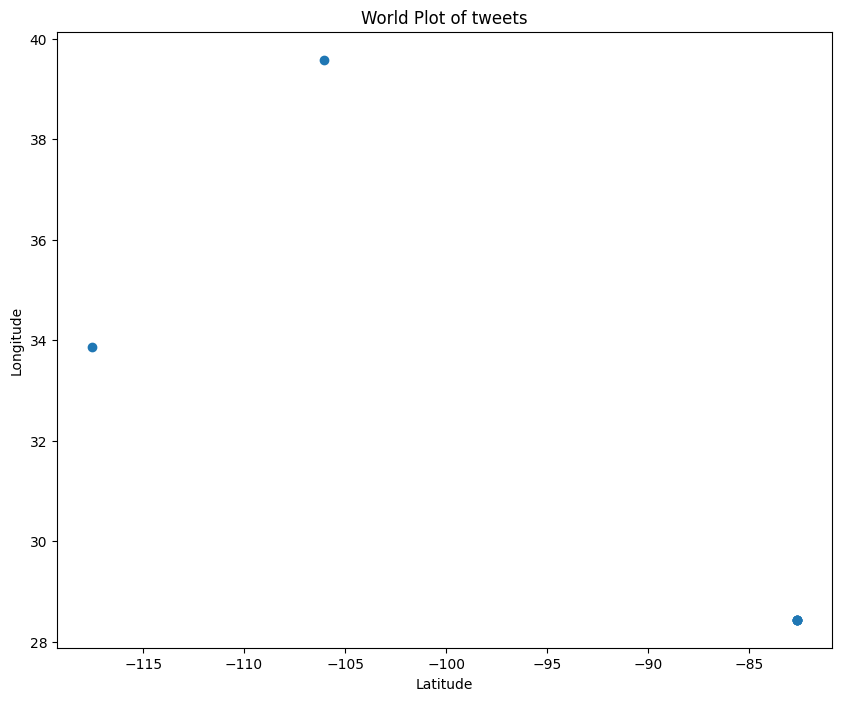

In [46]:

#create a scatterplot of sensor locations using latitude and longitude
plt.scatter(
    x=filtered['latitude'],
    y=filtered['longitude'])
#as always, label our axes and the plot!
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('World Plot of tweets')

In [47]:
import geopandas as gpd
from shapely.geometry import Point

#Create a GeoDataFrame from your tweet data
geometry = [Point(xy) for xy in zip(filtered['latitude'], filtered['longitude'])]
geo_df = gpd.GeoDataFrame(filtered, geometry=geometry)

#Load world shapefile (replace 'path_to_shape file' with the actual path to your shapefile)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

tweets_with_countries = gpd.sjoin(geo_df, world, how="inner", op='intersects')

country_counts = tweets_with_countries['name'].value_counts()
most_common_country = country_counts.idxmax()
most_common_count= country_counts.max()
print(f"The majority of the tweets come from {most_common_country} with {most_common_count} tweets.")


The majority of the tweets come from United States of America with 7 tweets.


<ipython-input-47-eed9ce176452>:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-47-eed9ce176452>:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  tweets_with_countries = gpd.sjoin(geo_df, world, how="inner", op='intersects')


revkin on twitter does not have their location listed, they are affiliated with the NYTimes so maybe new york (USA) other countries are Russia and Philippines (mentioned only once)

In [48]:
#the namme of your sample is filtered not filtered_sample

In [49]:
from ipyleaflet import Map, Circle, basemap_to_tiles, basemaps

# Assuming 'filtered' is your DataFrame with latitude and longitude columns
center = (filtered['latitude'].mean(), filtered['longitude'].mean())

m = Map(center=center, zoom=10, basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik))

for idx, row in filtered.iterrows():
    circle = Circle()
    circle.location = (row['longitude'], row['latitude'])
    circle.radius = 100
    circle.color = "red"
    circle.fill_color = "red"

    m.add_layer(circle)

# Display the map
m

Map(center=[-90.96336271428571, 30.800033285714285], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [50]:
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles, Circle

center = (filtered['longitude'].mean(), filtered['latitude'].mean())


m = Map(center=center, zoom=10, basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik))


for idx, row in filtered.iterrows():
    circle = Circle()
    circle.location = (row['longitude'], row['latitude'])
    circle.radius = 100
    circle.color = "red"
    circle.fill_color = "red"

    m.add_layer(circle)


m

Map(center=[30.800033285714285, -90.96336271428571], controls=(ZoomControl(options=['position', 'zoom_in_text'…

*Question:* What country are these tweets located in?

The map and the geodataframe and world shape file from our tweet data shows that the majority of the tweets come from United States of America with 7 tweets.